In [1]:
# imports
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math
import time
import pickle
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
try:
    import nbimporter
    from utils import helpful_functions as hf
    from utils.layers import squeeze_layer, preprocess_layer, coupling_layer, invertible_1x1_conv, int_shape, glow_coupling_layer, actnorm_layer
except:
    print("pip install nbimporter")
    raise Exception("need to install")

THIRTYTWO = 32
THREE = 1
DIM = THIRTYTWO * THIRTYTWO * THREE
WIDTH = 512


Importing Jupyter notebook from /home/ubuntu/flows/utils/helpful_functions.ipynb
Importing Jupyter notebook from /home/ubuntu/flows/utils/layers.ipynb


In [2]:
EXPERIMENT_NAME = "samples100"

In [3]:
training_data, train_labels_o, test_data, test_labels_o = hf.get_mnist(orig=True)

# 59,000 for training, 1000 for validation
training_data, train_labels_o, val_data, val_labels_o   = hf.split_train_val(training_data, train_labels_o, validation_size=1000)

# get 1000 for labed supervised training
training_data, train_labels_o, labeled_data, labeled_labels_o = hf.split_train_val(training_data, train_labels_o, validation_size=1000)

#hf.show_sample(training_data[0])

val_labels = hf.make_one_hot(val_labels_o)
labeled_labels = hf.make_one_hot(labeled_labels_o)
training_labels = hf.make_one_hot(train_labels_o)
test_labels = hf.make_one_hot(test_labels_o)

In [6]:
'''
Testing Simple Model (no multiscale)
'''
tf.reset_default_graph()
sess = tf.Session()

ph_x         = tf.placeholder(tf.float32, [None, THIRTYTWO, THIRTYTWO, THREE], name="x")
ph_inverse_z = tf.placeholder(tf.float32, [None, DIM], name="z")
op_init_actnorm = []

#DEPTH_PER_LEVEL = 2
#LEVELS = 1
DEPTH_PER_LEVEL = 16
LEVELS = 3

##### <flow network>
print("Building network!")
tf_layer = ph_x
tf_log_jacobian_determinant = 0
tf_layer, tf_log_det = preprocess_layer(tf_layer)
tf_log_jacobian_determinant += tf_log_det
for j in range(LEVELS):
    tf_layer = squeeze_layer(tf_layer)
    with tf.variable_scope("module_" + str(j)):
        for i in range(DEPTH_PER_LEVEL):
            with tf.variable_scope("layer_" + str(i)):
                tf_layer, tf_log_det, tf_conv_features = glow_coupling_layer(tf_layer, op_init_actnorm, return_conv_features=True)
                tf_log_jacobian_determinant += tf_log_det
                print(tf_conv_features.shape)

if False:
    restore_shape = list(tf_layer.shape)
    restore_shape[0] = -1
    tf_z = tf.reshape(tf_layer, (-1, DIM))

    ##### <inverse>
    print("Building inverse!")
    tf_layer = ph_inverse_z
    tf_layer = tf.reshape(tf_layer, restore_shape)
    for j in reversed(range(LEVELS)):
        with tf.variable_scope("module_" + str(j)):
            for i in reversed(range(DEPTH_PER_LEVEL)):
                with tf.variable_scope("layer_" + str(i)):
                    tf_layer = glow_coupling_layer(tf_layer, op_init_actnorm, reverse=True)
            tf_layer = squeeze_layer(tf_layer, reverse=True)     

    tf_layer = preprocess_layer(tf_layer, reverse=True)        
    tf_inverse_x = tf_layer

    tf_sample_summary = tf.summary.image("samples", tf_inverse_x)

    # <supervised training network>
    print("Building classifier!")
    def res_block(tf_in, hidden_dim):
        tf_layer = tf_in
        tf_layer = tf.layers.dense(inputs=tf_layer, units=hidden_dim, activation=tf.nn.relu)
        tf_layer = tf.layers.dense(inputs=tf_layer, units=hidden_dim)
        return tf.nn.relu(tf_layer + tf_in)

    FC_UNITS      = 64
    NUM_RES_BLOCKS = 1
    ph_y          = tf.placeholder(tf.int32, [None,10], name="x")

    tf_layer = tf.layers.dense(inputs=tf_z, units=FC_UNITS, activation=tf.nn.relu)
    with tf.name_scope("classifier"):
        for i in range(NUM_RES_BLOCKS):
            tf_layer = res_block(tf_layer, FC_UNITS)

        tf_logits = tf.layers.dense(inputs=tf_layer, units=10)

        tf_prob_y = tf.nn.softmax(tf_logits)
        tf_classifier_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=tf_logits, labels=ph_y))

        tf_true_labels = tf.argmax(input=ph_y, axis=1)
        tf_predicted_labels = tf.argmax(input=tf_logits, axis=1)
        tf_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf_true_labels, tf_predicted_labels), tf.float32))

        tf_classifier_validation_summary = tf.summary.merge([
            tf.summary.scalar("classifier_accuracy_validation", tf_accuracy)
        ])

        tf_classifier_summary = tf.summary.merge([
            tf.summary.scalar("classifier_accuracy", tf_accuracy),
            tf.summary.scalar("classifier_loss", tf_classifier_loss)
        ])

    ##### <loss> & training!!
    print("Building loss!")
    tf_global_step = tf.train.get_or_create_global_step()
    ph_learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")
    ph_lambda = tf.placeholder(tf.float32, shape=(), name="loss_weight")

    with tf.name_scope("flow_training"):
        tf_log_prob_z = - DIM * 0.5 * tf.log(2 * np.pi) - tf.reduce_sum(tf.square(tf_z) / 2.0, axis=-1)
        tf_flow_loss = tf.reduce_mean(
            (-tf_log_prob_z - tf_log_jacobian_determinant) / np.log(2) / DIM,
            name="loss"
        )

        optimizer = tf.train.AdamOptimizer(ph_learning_rate)
        tf_gradients, tf_variables = zip(*optimizer.compute_gradients(tf_flow_loss))
        tf_gradients, tf_gradients_norm = tf.clip_by_global_norm(tf_gradients, 100)
        op_flow_train = optimizer.apply_gradients(zip(tf_gradients, tf_variables), global_step=tf_global_step)

        tf_flow_validation_summary = tf.summary.merge([
            tf.summary.scalar("flow_loss_validation", tf_flow_loss)
        ])
        tf_flow_loss_summary = tf.summary.scalar("flow_loss", tf_flow_loss)
        tf_flow_summary = tf.summary.merge([
            tf_flow_loss_summary,
            tf.summary.scalar("flow_gradients_norm", tf_gradients_norm)
        ])

    with tf.name_scope("joint_training"):
        tf_joint_loss = tf_flow_loss * (1.0 - ph_lambda) + tf_classifier_loss * ph_lambda

        optimizer = tf.train.AdamOptimizer(ph_learning_rate)
        tf_gradients, tf_variables = zip(*optimizer.compute_gradients(tf_joint_loss))
        tf_gradients, tf_gradients_norm = tf.clip_by_global_norm(tf_gradients, 100)
        op_joint_train = optimizer.apply_gradients(zip(tf_gradients, tf_variables), global_step=tf_global_step)

        tf_joint_summary = tf.summary.merge([
            tf_flow_loss_summary,
            tf_classifier_summary,
            tf.summary.scalar("joint_loss", tf_joint_loss),
            tf.summary.scalar("joint_gradients_norm", tf_gradients_norm)
        ])

    tf_validation_summary = tf.summary.merge([
        tf_classifier_validation_summary,
        tf_flow_validation_summary
    ])


    op_init = tf.initializers.global_variables()
    sess.run(op_init)

    summary_writer = tf.summary.FileWriter('./log/{}'.format(EXPERIMENT_NAME), sess.graph)

    ###### <running init>
    print("Initializing act norm!")
    noise = np.random.uniform(0., 1, size=training_data[:100].shape)
    for op in op_init_actnorm:
        sess.run(op, feed_dict={ph_x: training_data[:100] + noise})
    loss_history = []

    print("Finished!")


Building network!
conv_features (?, 16, 16, 512)
affine features (?, 8, 8, 16)


In [ ]:
print(".")

In [78]:
###### <running forwards and backwards pass>
original = training_data[3:4,:,:,:]

z_state = sess.run(tf_z, feed_dict={ ph_x: original })
z1 = z_state
inv_img = sess.run(tf_inverse_x, feed_dict={ph_inverse_z: z_state})

###### <verification>
#hf.show_sample(original[0])
#hf.show_sample(inv_img[0])
assert hf.is_same(original[0], inv_img[0]) == 0

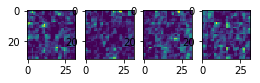

In [79]:
def show_some_samples():
    fig, ax = plt.subplots(nrows=1, ncols=4)
    fig.set_figheight(1)
    fig.set_figwidth(4)
    i = 120
    for col in ax:
        latent = np.random.normal(size=[DIM], scale=1)
        #print(latent.shape)
        sample = sess.run(tf_inverse_x, feed_dict={ph_inverse_z: [latent]})
        #print(sample.shape)
        hf.show_sample(sample[0], show=False, plot=col)
    plt.show()

show_some_samples()

In [80]:
np.random.seed(0)
VISUALIZATION_LATENTS = np.random.normal(size=[5, DIM], scale=1)
np.random.seed()

def train(training_data=None,
          validation_data=None,
          validation_labels=None,
          labeled_training=None,
          labeled_labels=None,          
          iterations=20000,
          flow_batch_size=64,
          flow_per_validation=1,
          loss_history=None,
          learning_rate=0.001,
          lambda_weight=0,
          supervised_batch_size=0
         ):

        
    if not callable(learning_rate):
        learning_rate_val = learning_rate
        learning_rate = lambda _: learning_rate_val
    
    if not callable(lambda_weight):
        learning_rate_val = lambda_weight
        lambda_weight = lambda _: learning_rate_val
    
    # training_data = training_data.copy() * 1.0
    validation_data = validation_data * 1.0
    validation_data += np.random.uniform(low=0., high=1.0, size=validation_data.shape)

    if loss_history == None:
        loss_history = []

    saver = tf.train.Saver(max_to_keep=3)

    step = 0
    training_loss, validation_loss = 0.0, 0.0
    supervised_loss, supervised_validation  = 0.0, 0.0
    best_validation = 10000

    start_time = time.time()
    un_sup_idx = 0
    sup_idx = 0
    
    if training_data is not None:
        train_count = len(training_data)
        total_batches = int(train_count / flow_batch_size)
    if labeled_training is not None:
        labeled_train_count = len(labeled_training)
        labeled_total_batches = int(labeled_train_count / supervised_batch_size)
    
    validation_step = 20
    save_step = 400

    for step in range(iterations):

        if step % validation_step == 0:
            # Add samples to tensorboard
            summary, global_step = sess.run([tf_sample_summary, tf_global_step], feed_dict={ph_inverse_z: VISUALIZATION_LATENTS})
            summary_writer.add_summary(summary, global_step)
            
            validation_loss, summary, global_step = sess.run(
                [tf_flow_loss, tf_validation_summary, tf_global_step],
                feed_dict={
                    ph_x: validation_data + np.random.uniform(low=0.0, high=1.0, size=validation_data.shape),
                    ph_y: validation_labels
                }
            )
            summary_writer.add_summary(summary, global_step)

        if step % save_step == 0:
            print("saving")
            save_path = saver.save(sess, "ckpts/model_{}_{}.ckpt".format(EXPERIMENT_NAME, step))
                    
                    
        for fpv in range(flow_per_validation):
            if not flow_batch_size == 0:

                if un_sup_idx == 0:
                    np.random.shuffle(training_data)
                minibatch = np.array(training_data[ (un_sup_idx*flow_batch_size) 
                                                  : ((un_sup_idx+1) * flow_batch_size) , :])
                un_sup_idx += 1
                un_sup_idx = un_sup_idx % total_batches

                training_loss, _, summary, global_step = sess.run(
                    [tf_flow_loss, op_flow_train, tf_flow_summary, tf_global_step],
                    feed_dict={
                        ph_x: minibatch + np.random.uniform(low=0.0, high=1.0, size=minibatch.shape),
                        ph_learning_rate: learning_rate(step)
                    }
                )
                summary_writer.add_summary(summary, global_step)

        if not supervised_batch_size == 0:

            # train supervised objective
            if sup_idx == 0:
                idxs = np.arange(0, labeled_train_count)
                np.random.shuffle(idxs)
                labeled_training  = labeled_training[idxs]
                labeled_labels    = labeled_labels[idxs]

            minibatch = np.array(labeled_training[(sup_idx*supervised_batch_size) 
                                                  : ((sup_idx+1) * supervised_batch_size) , :])
            minibatch_labels = np.array(labeled_labels[(sup_idx*supervised_batch_size) 
                                                       : ((sup_idx+1) * supervised_batch_size)])
            
            sup_idx += 1
            sup_idx = sup_idx % labeled_total_batches
            
            supervised_loss, _, summary, global_step = sess.run(
                [tf_joint_loss, op_joint_train, tf_joint_summary, tf_global_step],
                feed_dict={
                    ph_x: minibatch + np.random.uniform(low=0.0, high=1.0, size=minibatch.shape),
                    ph_y: minibatch_labels,
                    ph_learning_rate: learning_rate(step),
                    ph_lambda: lambda_weight(step)
                }
            )
            summary_writer.add_summary(summary, global_step)
            

        if step % 20 == 0:
            print("\tSteps =", step, "\tTraining loss =", training_loss, "\tSupervised loss =", supervised_loss)

        loss_history.append((training_loss, validation_loss, supervised_loss, supervised_validation))
        validation_loss = None
        supervised_validation = None

# Experiments

In [81]:
# load a checkpoint
# # restore to previous model
if False:
    print("start loading")
    
    checkpoint_dir = "trained_ckpts_mnist_16_depth"
    model_number = 199
    #print(variables_can_be_restored)
    variables_can_be_restored = tf.train.list_variables(checkpoint_dir)
    
    tf.train.load_variable('/home/user/logdir/checkpoint', 'variable_name')
    
    
    temp_saver = tf.train.Saver(variables_can_be_restored)
    ckpt_state = tf.train.get_checkpoint_state(checkpoint_dir, "model_" + str(model_number) +  ".ckpt")
    print('Loading checkpoint %s' % ckpt_state.model_checkpoint_path)
    temp_saver.restore(sess, ckpt_state.model_checkpoint_path)

    
    print("done loading")

In [ ]:
## Only Unsupervised
def lr_with_warmup(step):
    warmup_steps = 250
    learning_rate = 1e-3
    return min(learning_rate * step / warmup_steps, learning_rate)

train(
    training_data,
    val_data,
    val_labels,
    iterations=500,
    flow_batch_size=64*2,
    loss_history=loss_history,
    learning_rate=lr_with_warmup
)

In [60]:
## Only Joint Training

def lr_with_warmup(step):
    warmup_steps = 1000
    learning_rate = 1e-3
    return min(learning_rate * step / warmup_steps, learning_rate)

def lambda_with_warmup(step):
    warmup_steps = 500
    lambda_val = 1
    return min(lambda_val * step / warmup_steps, lambda_val)


train(training_data=None,
      validation_data=val_data,
      validation_labels=val_labels,
      labeled_training=labeled_data[:100],
      labeled_labels=labeled_labels[:100],
      iterations=20000,
      flow_batch_size=0,
      loss_history=loss_history,
      learning_rate=lr_with_warmup,
      lambda_weight=lambda_with_warmup,
      supervised_batch_size=64
)

saving
	Steps = 0 	Training loss = 0.0 	Supervised loss = 8.537121
	Steps = 20 	Training loss = 0.0 	Supervised loss = 4.8443227
	Steps = 40 	Training loss = 0.0 	Supervised loss = 4.3209615
	Steps = 60 	Training loss = 0.0 	Supervised loss = 3.9000802
	Steps = 80 	Training loss = 0.0 	Supervised loss = 3.3920403
	Steps = 100 	Training loss = 0.0 	Supervised loss = 2.8421814
	Steps = 120 	Training loss = 0.0 	Supervised loss = 2.146257
	Steps = 140 	Training loss = 0.0 	Supervised loss = 1.9767644
	Steps = 160 	Training loss = 0.0 	Supervised loss = 1.6928744
	Steps = 180 	Training loss = 0.0 	Supervised loss = 1.3831701
	Steps = 200 	Training loss = 0.0 	Supervised loss = 1.1517577
	Steps = 220 	Training loss = 0.0 	Supervised loss = 1.015177
	Steps = 240 	Training loss = 0.0 	Supervised loss = 0.94834316
	Steps = 260 	Training loss = 0.0 	Supervised loss = 0.83845997
	Steps = 280 	Training loss = 0.0 	Supervised loss = 0.7334696
	Steps = 300 	Training loss = 0.0 	Supervised loss = 0.

KeyboardInterrupt: 

In [ ]:
# compute NLL
def nll(images, true_labels):
    batch_size = 64
    probs = []
    total_batches = len(images) // batch_size
    for qwe in range(total_batches):
        minibatch = np.array(images[ (qwe*batch_size) : ((qwe+1) * batch_size) , :])
        prob = sess.run( [tf_prob_y],
                        feed_dict={
                            ph_x: minibatch + np.random.uniform(low=0.0, high=1.0, size=minibatch.shape),
                        })
        probs += prob
    
    computed_num = total_batches * batch_size
    nll_list = []
    #print(probs)
    prob_list = probs[0]
    # print(prob_list)
    for p, label in zip(prob_list, true_labels[:computed_num]):
        #print(label)
        #print(p)
        nll_list.append(-np.log(p[label]))
        
    return np.mean(np.array(nll_list))

In [ ]:
nll(test_data, test_labels_o)

In [ ]:
index=20
im_test = test_data[index:index+1]
im_label = test_labels[index:index+1]
prob, true_labels, pred_labels = sess.run( [tf_prob_y, tf_true_labels, tf_predicted_labels],
                feed_dict={
                    ph_x: im_test + 0.5,# np.random.uniform(low=0.0, high=1.0, size=im_test.shape),
                    ph_y: im_label
                })
print(prob, true_labels, pred_labels)
hf.show_sample(im_test[0])

In [ ]:
## Semi Supervised Learning
# Only classifer

def lr_with_warmup(step):
    warmup_steps = 1000
    learning_rate = 1e-3
    return min(learning_rate * step / warmup_steps, learning_rate)

def lambda_weight_with_warmup(step):
    warmup_steps = 10000
    lambda_weight = 0.95
    return min(lambda_weight * step / warmup_steps, lambda_weight)


train(training_data=None,
      validation_data=val_data,
      validation_labels=val_labels,
      labeled_training=labeled_data,
      labeled_labels=labeled_labels,          
      iterations=2000,
      flow_batch_size=0,
      flow_per_validation=0,
      loss_history=loss_history,
      learning_rate=lr_with_warmup,
      lambda_weight=0.5,
      supervised_batch_size=32
     )

In [ ]:
## Semi Supervised Learning
#  classifer with all unlabled samples

def lr_with_warmup(step):
    warmup_steps = 1000
    learning_rate = 1e-3
    return min(learning_rate * step / warmup_steps, learning_rate)

def lambda_weight_with_warmup(step):
    warmup_steps = 10
    lambda_weight = 0.95
    return min(lambda_weight * step / warmup_steps, lambda_weight)


train(training_data=training_data[0:50000],
      validation_data=val_data,
      validation_labels=val_labels,
      labeled_training=labeled_data,
      labeled_labels=labeled_labels,          
      iterations=200000,
      flow_batch_size=64,
      flow_per_validation=1,
      loss_history=loss_history,
      learning_rate=lr_with_warmup,
      lambda_weight=0.5,
      supervised_batch_size=32
     )

In [ ]:
# save loss histroy
with open('loss_histroy_single_scale_exp3.pkl', 'wb') as f:
    pickle.dump(loss_history, f)
loss_history

# sucsessful unit tests on layers